Do exercises have a greater impact on the movement frequencies of wrist/elbow than of shoulder?

In [1]:
import numpy as np
import numpy as np
import pandas as pd

from sklearn.preprocessing import normalize
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from scipy.fft import rfft, rfftfreq #outputs half
from scipy.signal import find_peaks

In [2]:
'''Column names of limbs that we care about atm:
- STRN
- LASI
- LSHO 
- LELB 
- LFIN
- LWRA
- LWRB'''

'''-------------CHOICES--------------'''
angLSHO = ["LASI","LSHO","LELB"]
angLELB = ["LSHO","LELB","LWRA"]
angLWRA = ["LELB","LWRA","LFIN"]
angRSHO = ["RASI","RSHO","RELB"]
angRELB = ["RSHO","RELB","RWRA"]
angRWRA = ["RELB","RWRA","RFIN"]

coarseness = 20 #min: 5 

#Frequency plotting things
angLST = [angLSHO,angLELB,angLWRA,angRSHO,angRELB,angRWRA] # list of angles to loop through
limbLST = ['LSHO','LELB','LWRA','RSHO','RELB','RWRA'] # list of angles to loop through

In [8]:
def np_piece_data_from_csv(num, piece, deriv=False):
    if deriv:
        filename = f'/Users/HAQbook/Desktop/graaaaphs/data/piano01_00{str(piece)}_p{str(num)}_d.csv' #performance number 1-6
    else:
        filename = f'/Users/HAQbook/Desktop/graaaaphs/data/piano01_00{str(piece)}_p{str(num)}.csv' #performance number 1-6
    repo = pd.read_csv(filename,header=0)
    columns=['Frame', 'Time (Seconds)']
    repo = repo.drop(columns, axis=1)
    vals = repo.to_numpy(dtype=float)
    mask = np.isnan(vals)
    vals[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), vals[~mask])

    return repo, vals

In [9]:
def getDegrees2D(repo, vals, POINTSx): # duplicate in 'degrees2D.ipynb'
    '''Gets angle between three points ps=[p1,p2,p3] over all frames'''
    p1x = repo.columns.get_loc("piano_pilot_01:"+POINTSx[0]+"x") # get the x,y,z data for each of the three points over all frames
    p2x = repo.columns.get_loc("piano_pilot_01:"+POINTSx[1]+"x")
    p3x = repo.columns.get_loc("piano_pilot_01:"+POINTSx[2]+"x")

    unit_vector = lambda x: normalize(x, axis = 1, norm = 'l2') # helper function to normalise vectors, anonymous function woah

    v1 = vals[:,p1x:p1x+3] - vals[:,p2x:p2x+3] # 3 points -> 2 vectors
    v2 = vals[:,p3x:p3x+3] - vals[:,p2x:p2x+3]
    v1_u = unit_vector(v1) # vectors -> unit vectors
    v2_u = unit_vector(v2)
    ang = np.rad2deg(np.arccos(np.sum(v1_u*v2_u, axis=1))) # calculate angle between vectors
    return(ang) 

In [10]:
def standardize_len(lists: list[np.array]):
    '''standardize the length of the arrays by interpolation 
    (sort of stretching them performances to all be the same length for ease of comparison)'''
    x = np.linspace(0, len(lists[0]) - 1, len(lists[0]))
    standardized_len_lists = []
    for lst in lists:
        #Stretch/compress y to be the length of first list
        xp = np.linspace(x[0], x[-1], len(lst))
        new_lst = np.interp(x, xp, lst) 
        standardized_len_lists.append(new_lst) 
    return(standardized_len_lists)
    
def removeOutliers(y):
    # Calculate the IQR fences
    #print(f'{np.min(y)=} and {np.max(y)=}')
    x = np.linspace(np.min(y), np.max(y), num=len(y)) #set of x values that cover the range of the data and are sufficiently dense to capture any rapid changes in the y values. 
    Q1 = np.percentile(y, 25)
    Q3 = np.percentile(y, 75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    # Smooth the outliers with linear interpolation
    outliers = (y < lower_fence) | (y > upper_fence)
    x_outliers = x[outliers]
    f = interp1d(x[~outliers], y[~outliers], kind='linear', bounds_error=False, fill_value='extrapolate')
    y_smoothed = f(x_outliers)

    # Replace the outliers with the smoothed values
    y[outliers] = y_smoothed
    return(y)

def smooth(a, ker = 80):
    kernel_size = ker
    kernel = np.ones(kernel_size) / kernel_size
    a = np.convolve(a, kernel, mode='same') 
    a_cleaner = removeOutliers(a)
    return(a_cleaner)



def plot_fft(piece: int, perfs: list[int], limb: list[str], smoothker: int, xlim: list[int] = [0,3], ylim: list[int] = [0,27500], DERIV: bool = False, save: bool = False) -> None:
    fig1 = plt.figure(figsize=(10, 6))
    ax1 = fig1.add_subplot(111)

    fig2 = plt.figure(figsize=(10, 6))
    ax2 = fig2.add_subplot(111)

    angLST = []
    for perf in perfs:
        repo,vals = np_piece_data_from_csv(perf,piece,deriv=DERIV)
        ang = smooth(getDegrees2D(repo, vals, POINTSx = limb), ker=smoothker)
        angLST.append(ang)

    stand_len_angLST = standardize_len(angLST)

    for count,elem in enumerate(stand_len_angLST):
        labl = f'{limb[1]}_perf{elem}'
        ln=np.size(elem,0)
        X = np.linspace(0, ln//240, ln) 
        N = np.size(X)
        yf = rfft(elem)
        xf = rfftfreq(N, 1/(sr := 240))
        ax1.plot(X, elem, label=perfs[count])
        ax2.plot(xf, np.abs(yf), label=perfs[count])

    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel("Amplitude")
    ax1.legend()
    ax1.set_title(f'{limb[1]} angle, piece {piece} over time, smoothed with a kernel of {smoothkernel}')

    ax2.set_xlabel("Frequency [Hz]")
    ax2.set_ylabel("Amplitude")
    ax2.legend()
    ax2.set_title(f'{limb[1]} angle, piece {piece} frequency plot, from data smoothed with a kernel of {smoothkernel}')
    ax2.set_xlim(xlim[0],xlim[1])
    ax2.set_ylim(ylim[0],ylim[1])

    if save:
        plt.savefig(f'visuals/frequencies_piece{piece}.png')

In [11]:
def plot_fft_w_peaks(piece: int, perfs: list[int], limb: list[str], smoothker: int, PROMINENCE: float = 0.5, WIDTH: float = 0.2, xlim: list[int] = [0,3], ylim: list[int] = [0,27500], nonFFTplot = False, DERIV: bool = False, PLOT: bool = True, save: bool = False):
    if PLOT:
        if nonFFTplot:
            fig1 = plt.figure(figsize=(10, 6))
            ax1 = fig1.add_subplot(111)

        fig2 = plt.figure(figsize=(10, 6))
        ax2 = fig2.add_subplot(111)

    angLST = []
    for perf in perfs:
        repo,vals = np_piece_data_from_csv(perf,piece,deriv=DERIV)
        ang = smooth(getDegrees2D(repo, vals, POINTSx = limb), ker=smoothker)
        angLST.append(ang)

    stand_len_angLST = standardize_len(angLST)
    peakLST = []
    for count,elem in enumerate(stand_len_angLST):
        labl = f'{limb[1]}_perf{elem}'
        ln=np.size(elem,0)
        X = np.linspace(0, ln//240, ln) 
        N = np.size(X)
        yf = rfft(elem)
        xf = rfftfreq(N, 1/(sr := 240))

        # Find the peaks in the signal
        peaks, _ = find_peaks(np.abs(yf), prominence=PROMINENCE, width=WIDTH)
        if PLOT:
            if nonFFTplot: ax1.plot(X, elem, label=perfs[count])
            ax2.plot(xf, np.abs(yf), label=perfs[count])
            ax2.plot(xf[peaks], np.abs(yf)[peaks], "x")

        # add the index of the peaks, the x and the y values at which they occur to a list
        peakLST.append([peaks, xf[peaks], np.abs(yf)[peaks]])

    if PLOT:
        if nonFFTplot:
            ax1.set_xlabel("Time [s]")
            ax1.set_ylabel("Amplitude")
            ax1.legend()
            ax1.set_title(f'{limb[1]} angle, piece {piece} over time, smoothed with a kernel of {smoothkernel}, {DERIV=}')
        ax2.set_xlabel("Frequency [Hz]")
        ax2.set_ylabel("Amplitude")
        ax2.legend()
        ax2.set_title(f'{limb[1]} angle, piece {piece} frequency plot, from data smoothed with a kernel of {smoothkernel},  {DERIV=}')
        ax2.set_xlim(xlim[0],xlim[1])
        ax2.set_ylim(ylim[0],ylim[1])

    if save:
        plt.savefig(f'visuals/frequencies_piece{piece}.png')

    return(peakLST)

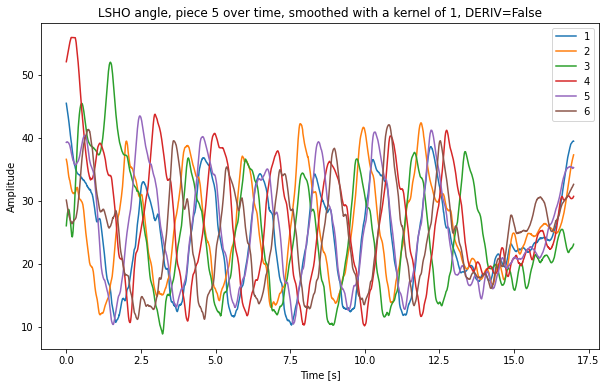

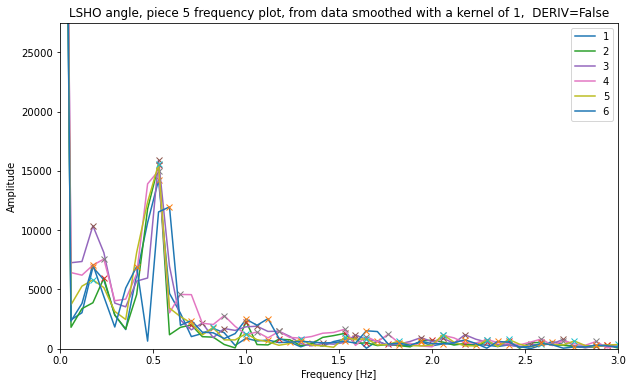

In [12]:
piece = 5 # can choose either multiple pieces or multiple performances for one angle
perfs = [1,2,3,4,5,6]
limb = ["LASI","LSHO","LELB"]

smoothkernel = 1
p = 1
w = 0.5
p = plot_fft_w_peaks(piece, perfs, limb, smoothkernel, nonFFTplot=True, PROMINENCE = p, WIDTH = w)
